In [1]:
from src.bertopic_pipeline import BERTopicPipeline
import polars as pl
import matplotlib.pyplot as plt
import ruptures as rpt
from pathlib import Path
from src.change_point_detection import *

embedding_models = [
    'text-embedding-3-large', 
    'all-mpnet-base-v2',
    'all-MiniLM-L12-v2']

model_base_dir = Path('models')
topic_models = {}
overall_benchmarkings = {}
for model in embedding_models: 
    tmp_topic_model = BERTopicPipeline(model).load(model_base_dir / f'topic_model_{model}')
    topic_models[model] = tmp_topic_model
    overall_benchmarkings[model] = tmp_topic_model.topic_quality_all

c:\Users\povhi\anaconda3\envs\ip\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-10 12:49:27.702 | INFO     | src.bertopic_pipeline:_load_embedding_data:45 - Loading embedding data for text-embedding-3-large from c:/Users/povhi/OneDrive/01_Uni/03_TU Wien/MSc Data Science/09_Interdisciplinary_Project/ECB_Topic_Chronicles/data/embeddings_text-embedding-3-large.parquet
2025-08-10 12:49:29.814 | INFO     | src.bertopic_pipeline:_load_embedding_data:47 - Loaded 3702 rows of embedding data for text-embedding-3-large.
2025-08-10 12:49:29.815 | INFO     | src.bertopic_pipeline:_load_embedding_data:48 - Data columns: ['content', 'related_topics', 'id', 'date', 'author', 'title', 'url', 'language', 'type_long', 'tokens', 'chunks', 'chunks_embeddings']
2025-08-10 12:49:36.405 | INFO     | src.bertopic_pipeline:_load_

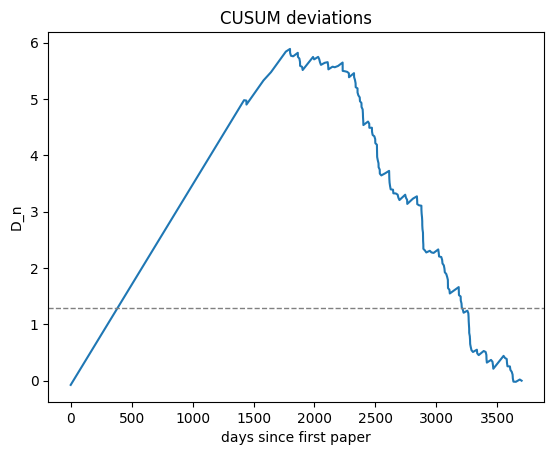

change @ idx 7  2019-11-20T12:00:00.000000000  lambda=5.889  crit=1.299


In [26]:
df = topic_models['all-MiniLM-L12-v2'].data
df = clean_up_time_series_data(df)
events = create_time_series_events(df)
event_days, D, critical_value = calculate_cumsum_statistics(events, plot = True)
cps, info = galeano_binary_segmentation(events, alpha0=0.05, nsim=20_000)
for d in info:
    print(f"change @ idx {d['index']}  {d['date']}  "
        f"lambda={d['stat']:.3f}  crit={d['crit']:.3f}")

In [76]:
from datetime import date
import statsmodels.api as sm

# y    = df['cnt_0']
# post = (df.get_column('period')>= date(2019, 11, 20)).cast(pl.Int8)
# exog = sm.add_constant(post)
# model = sm.GLM(y.to_numpy(), exog, family=sm.families.Poisson())
# res   = model.fit(cov_type="HC0")   # robust SEs
# print(res.summary())


family = "poisson"

y    = df['cnt_0']
post = (df.get_column('period')>= date(2019, 11, 20)).cast(pl.Int8)
X = sm.add_constant(pd.DataFrame({"post": post}))
offset = (
    df.select(
        pl.when(pl.col("total") < 1.0)
          .then(1.0)
          .otherwise(pl.col("total"))
          .log()
          .alias("offset")
    )
    .to_pandas() 
)['offset']

fam = sm.families.Poisson() if family=="poisson" else sm.families.NegativeBinomial(alpha=1.0)
res = sm.GLM(y, X, family=fam, offset=offset).fit(cov_type="HC0")  # robust SE

irr = float(np.exp(res.params["post"]))                                # incidence rate ratio
ci_lo, ci_hi = np.exp(res.conf_int().loc["post"].values)
overdisp = float(res.pearson_chi2 / res.df_resid)       

print({"IRR":irr, "CI":(float(ci_lo), float(ci_hi)), "overdisp":overdisp})
print(res.summary())

{'IRR': 101.0977443609027, 'CI': (47.52272263718002, 215.07088288889616), 'overdisp': 0.8387296000943036}
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10231
Model:                            GLM   Df Residuals:                    10229
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -600.14
Date:                 So, 10 Aug 2025   Deviance:                       858.38
Time:                        15:02:06   Pearson chi2:                 8.58e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04805
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [82]:
from datetime import date
import polars as pl, pandas as pd, numpy as np, statsmodels.api as sm

# inputs
share = df['pct_0']            # monthly share; 0–1 or 0–100
n     = df['total']                    # total speeches that month
post  = (df.get_column('period') >= date(2019, 11, 20)).cast(pl.Int8)

# prep
y = share.to_numpy()
y = np.clip(y, 1e-6, 1-1e-6)           # avoid 0/1 separation
n = n.to_numpy()

X = sm.add_constant(pd.DataFrame({"post": post.to_numpy()}))

# fit
res = sm.GLM(y, X, family=sm.families.Binomial()).fit(freq_weights=n, cov_type="HC0")

# effects
OR = float(np.exp(res.params["post"]))
ci_lo, ci_hi = np.exp(res.conf_int().loc["post"].values)
p_hat = res.predict(X)
pre  = float(p_hat[post.to_numpy()==0].mean())
postm= float(p_hat[post.to_numpy()==1].mean())
RR   = postm / pre if pre>0 else np.nan

print({"OR":OR, "CI":(ci_lo, ci_hi), "pre_p":pre, "post_p":postm, "RR":RR})
print(res.summary())  # optional


{'OR': 109.20366468355627, 'CI': (51.192336413334814, 232.95362579333656), 'pre_p': 0.0008422433601729984, 'post_p': 0.08429402513088767, 'RR': 100.0827422534664}
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10231
Model:                            GLM   Df Residuals:                    10229
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -608.86
Date:                 So, 10 Aug 2025   Deviance:                       1217.4
Time:                        15:02:09   Pearson chi2:                 1.02e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04735
Covariance Type:                  HC0                                         
                 coef    std err          z    

In [83]:
from statsmodels.stats.multitest import multipletests

# ---- data to pandas
p = df.select("period","cnt_0","total").to_pandas()
p["period"] = pd.to_datetime(p["period"])
p = p.sort_values("period").reset_index(drop=True)

# ---- candidate breakpoints (trim ends to ensure pre/post data exists)
trim = 6  # months to keep on each side
cands = p["period"].unique()
cands = cands[trim:len(cands)-trim]

rows = []
y_cnt = p["cnt_0"].to_numpy(float)
N     = p["total"].to_numpy(float)
off   = np.log(np.clip(N, 1.0, None))

# ---------- Binomial (logit) scan ----------
rows = []
y_prop = (y_cnt / np.clip(N,1.0,None)).clip(1e-6, 1-1e-6)  # proportions for GLM; weights=N

for d in cands:
    post = (p["period"] >= d).astype(int).to_numpy()
    X = sm.add_constant(pd.DataFrame({"post": post}))
    res = sm.GLM(y_prop, X, family=sm.families.Binomial()).fit(freq_weights=N, cov_type="HC0")
    b  = res.params["post"]; se = res.bse["post"]; pval = res.pvalues["post"]
    OR = float(np.exp(b))
    # quick direction check via model preds
    phat = res.predict(X)
    pre  = float(phat[post==0].mean()); postm = float(phat[post==1].mean())
    RR   = postm/pre if pre>0 else np.nan
    rows.append({"date": d, "beta": b, "OR": OR, "RR_hat": RR, "z": float(b/se), "p": float(pval)})

scan_binom = pd.DataFrame(rows).sort_values("p").reset_index(drop=True)
scan_binom["dir"] = np.where(scan_binom["beta"]>0, "up", "down")
scan_binom["p_fdr"] = multipletests(scan_binom["p"].values, method="fdr_bh")[1]

print(scan_binom.head(10))
# scan_binom[scan_binom["p_fdr"]<0.05]

NameError: name 'multipletests' is not defined

In [ ]:
import numpy as np

p = scan_binom["p"].to_numpy()
m = len(p)
order = np.argsort(p)
rank  = np.arange(1, m+1)
p_sorted = p[order]
q = (m / rank) * p_sorted
q = np.minimum.accumulate(q[::-1])[::-1]  # monotone
p_fdr = np.clip(q, 0, 1)
scan_binom["p_fdr"] = p_fdr[np.argsort(order)]




,date,beta,OR,RR_hat,z,p,dir,p_fdr
0,1997-02-13,9.476128,13044.582232,12876.608163,115.382580,0.000000,up,0.000000
1,2009-01-13,10.040380,22934.091996,22419.933594,121.740168,0.000000,up,0.000000
2,2009-01-12,10.040206,22930.098307,22416.116955,121.738262,0.000000,up,0.000000
3,2009-01-11,10.040032,22926.106009,22412.301616,121.736355,0.000000,up,0.000000
4,2009-01-10,10.039857,22922.115101,22408.487576,121.734449,0.000000,up,0.000000
...,...,...,...,...,...,...,...,...
10214,2025-01-22,1.401195,4.060049,3.907043,1.361359,0.173400,up,0.173468
10215,2025-01-21,1.349803,3.856667,3.720633,1.313062,0.189162,up,0.189218
10216,2025-01-20,1.300915,3.672656,3.551169,1.266933,0.205179,up,0.205219
10217,2025-01-19,1.254297,3.505373,3.396441,1.222790,0.221409,up,0.221431


In [ ]:
scan_binom

dir
up      10216
down        3
Name: count, dtype: int64